In [101]:
%matplotlib notebook
# load plotting tools
import matplotlib.pyplot as plt
# import matplotlib.animation
# plt.rcParams["animation.html"] = "jshtml"
# load numpy
import numpy as np
# load os and cli manipulators
import os
import subprocess

In [103]:
# get the number of generations by counting the number of files
genNo = len(os.listdir('./data'))
# get te number of individuals by counting the number of lines
indNo = sum(1 for line in open('./data/gen0.txt'))
# the shell command to get the number of variables+1 is
# 'head -1 ./data/gen0.txt | grep -o "," | wc -l'
# which is equivalent to the next python commands
sampleInd = subprocess.Popen(('head', '-1', './data/gen0.txt'), stdout=subprocess.PIPE)
elements = subprocess.check_output(('grep', '-o', ','), stdin=sampleInd.stdout)
varNo = str(elements).count(',')-1
# store all generations, individuals and variables + 2 objectives
gen = np.zeros((genNo,indNo,varNo+2))
# read the files
for i in range(genNo):
    gen[i,:] = np.genfromtxt('./data/gen%d.txt' %i, delimiter=',')

In [3]:
import scipy.optimize
# Notebook variables (copied here to avoid expensive recomputations of the
# same values each generation evaluation)
# Fixed ice temperature
Tice = -10+273.15
# Fixed volume of the snow pile
fixedVol = 10000
# Surface heat conductive coefficient
k_soil = 3.0
# Ground temperature from the probes data
Tgnd = 282.4788753177849
# Ground probe depth
d = 1
# Average air convective heat transfer coefficient
h = 9.813040255272988
# Infinite temperature for the convective heat
Tinf = 279.63818897637805
# Solar incidence value from NOAA data
Gsolar = 144.61805555555554
# Sky temperature for the radiative heat
Tsky = 263.3815936815641
# Stephan Boltzmann constant in SI units
sigma = 5.67036713e-8

################################################################################
#                                  FUNCTION                                    #
################################################################################

# Function to compute the volume of the pile
def vol(alpha, b, H, l):
    # Get the upper side of the trapezoid
    b2 = b - 2*H*np.tan(np.deg2rad(90-alpha))
    # Get the trapezoidal area
    frontArea = H*(b+b2)/2
    # Get the volume with the length
    volume = frontArea*l
    return volume

# Lambda function for the solution of the equation
fVol = lambda l, b, H, alpha, fixedVol : vol(alpha, b, H, l)-fixedVol

# Function for surface temperature optimization
def Tsurf_fun(Tsurf, *data):
    h, Tinf, Ains, Gsolar, Eins, sigma, Tsky, Kins, Tice, Tins = data
    # convective heat
    qconv = h*(Tinf-Tsurf)
    # radiative heat
    qrad = Ains*Gsolar + Eins*sigma*(Tsky**4-Tsurf**4)
    # conductive heat
    qins = Kins*(Tsurf-Tice)/Tins
    return qconv + qrad - qins

<IPython.core.display.Javascript object>


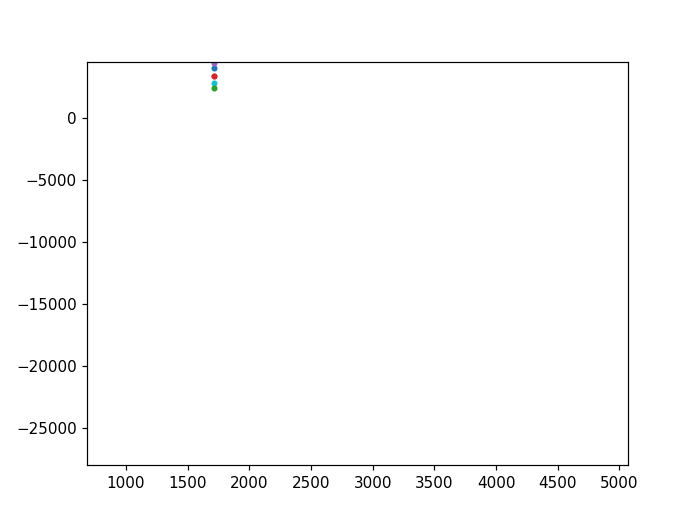

In [5]:
ax = plt.subplot(1, 1, 1)
# Loop over all individuals
for ind in range(len(gen[0,:,0])):
    #Get the variables for each individual
    alpha = gen[0,ind,0]
    b = gen[0,ind,1]
    H = gen[0,ind,2]
    Tins = gen[0,ind,3]
    Kins = gen[0,ind,4]
    Eins = gen[0,ind,5]
    Ains = gen[0,ind,6]

    # each individual will require the solution of two equations with fsolve
    # length of the snow pile
    l = scipy.optimize.fsolve(fVol, 1e3, args=(b, H, alpha, fixedVol))
    # surface temperature of the snow pile outer insulator
    Tsurf = scipy.optimize.fsolve(Tsurf_fun, Tice,
                              args=(h, Tinf, Ains, Gsolar, Eins, sigma, Tsky,
                                    Kins, Tice, Tins))

    # AIR SURFACES
    # Conductive heat through the insulation
    qins = Kins*(Tsurf-Tice)/Tins
    # Upper base width
    b2 = b - 2*H*np.tan(np.deg2rad(90-alpha))
    # Lateral size
    ls = H/np.cos(np.deg2rad(90-alpha))
    # Air surface is 2*(trapezoidal front) + (upper rectangle) + 2*(side rectangles)
    air_surf = 2*(H*(b+b2)/2) + (b2*l) + 2*(ls*l)
    # Air surface heat is
    qair = qins*air_surf

    # SOIL SURFACES
    # Conductive heat of the ground
    qgnd = k_soil*(Tgnd-Tice)/d
    # Soil surface is simply the rectangle given by
    soil_surf = b*l
    # Soil surface heat is
    qsoil = qgnd*soil_surf
    
    ax.plot(np.abs(qsoil), np.abs(qair),'.')

In [16]:
gen[0,:,-2].max()

51210136.995056

<IPython.core.display.Javascript object>


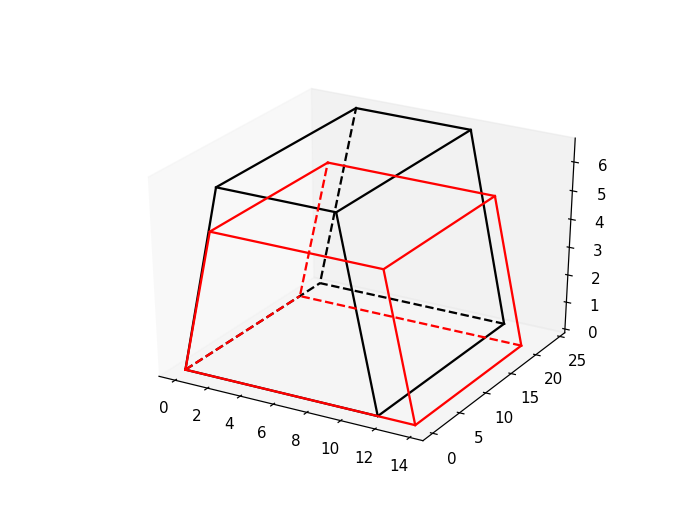

In [74]:
from mpl_toolkits import mplot3d

alpha = gen[-1,12,:-2][0]
b = gen[-1,12,:-2][1]
H = gen[-1,12,:-2][2]
b2dif = H*np.tan(np.deg2rad(90-alpha))

# plot a sample pile
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.grid(False)
ax.plot([b2dif,b-b2dif,b],[l/b,l/b,l/b],[H,H,0],'k')
ax.plot([b,0,b2dif],[l/b,l/b,l/b],[0,0,H],'k--')
ax.plot([0,b2dif,b-b2dif,b,0],[0,0,0,0,0],[0,H,H,0,0],'k')
ax.plot([0,0],[0,l/b],[0,0],'k--')
ax.plot([b2dif,b2dif],[0,l/b],[H,H],'k')
ax.plot([b-b2dif,b-b2dif],[0,l/b],[H,H],'k')
ax.plot([b,b],[0,l/b],[0,0],'k')

alpha = gen[-2,66,:-2][0]
b = gen[-2,66,:-2][1]
H = gen[-2,66,:-2][2]
b2dif = H*np.tan(np.deg2rad(90-alpha))

# plot a sample pile
ax.grid(False)
ax.plot([b2dif,b-b2dif,b],[l/b,l/b,l/b],[H,H,0],'r')
ax.plot([b,0,b2dif],[l/b,l/b,l/b],[0,0,H],'r--')
ax.plot([0,b2dif,b-b2dif,b,0],[0,0,0,0,0],[0,H,H,0,0],'r')
ax.plot([0,0],[0,l/b],[0,0],'r--')
ax.plot([b2dif,b2dif],[0,l/b],[H,H],'r')
ax.plot([b-b2dif,b-b2dif],[0,l/b],[H,H],'r')
ax.plot([b,b],[0,l/b],[0,0],'r')

In [35]:
2*H*np.tan(np.deg2rad(90-alpha))

5.773502691896257

In [ ]:
2*H*np.tan(np.deg2rad(90-alpha)) > b

In [70]:
gen[-2,:,-1].argmin()

66

<IPython.core.display.Javascript object>


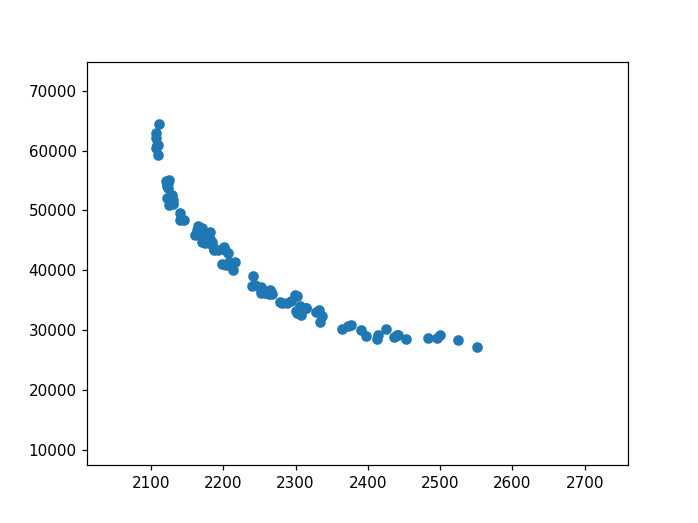

(0, 400000.0)

In [105]:
ax = plt.subplots(1)
# for i in range(genNo):
#     plt.plot(gen[i,:,-1],gen[i,:,-2],'.')
plt.plot(gen[-1,:,-1],gen[-1,:,-2],'o')
plt.xlim(0,5e3)
plt.ylim(0,4e5)

<IPython.core.display.Javascript object>


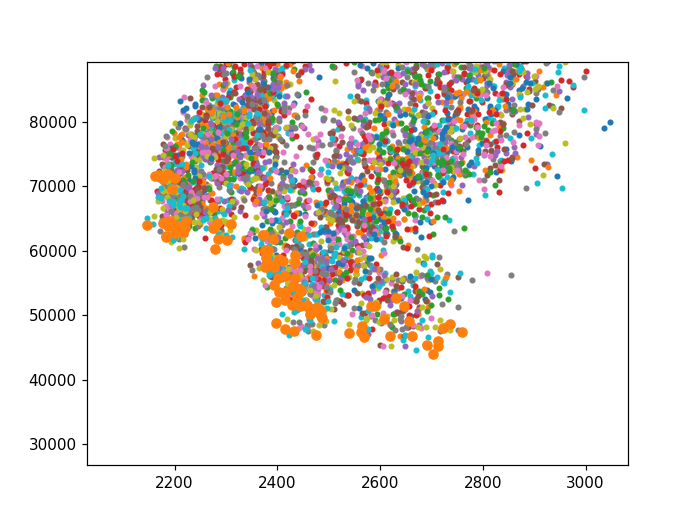

(0, 400000.0)

In [100]:
ax = plt.subplots(1)
for i in range(genNo):
    plt.plot(gen[i,:,-1],gen[i,:,-2],'.')
plt.plot(gen[-1,:,-1],gen[-1,:,-2],'o')
plt.xlim(0,5e3)
plt.ylim(0,4e5)

<IPython.core.display.Javascript object>


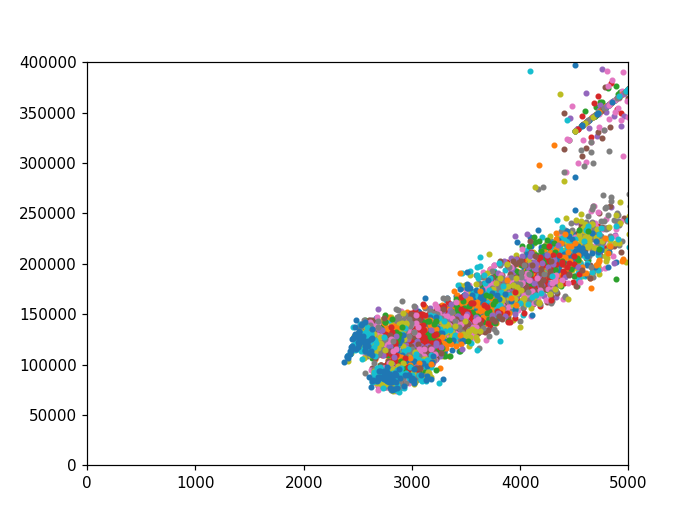

(0, 400000.0)

In [96]:
ax = plt.subplots(1)
for i in range(genNo):
    plt.plot(gen[i,:,-1],gen[i,:,-2],'.')
plt.xlim(0,5e3)
plt.ylim(0,4e5)

In [3]:
# define the plot
fig, ax = plt.subplots(figsize=(12,12))
# empty variable where we store the returned plots
dots = None
# 'close' the figure to avoid extra empty axis
plt.close()
# define init function
def init():
    ax.clear()
    ax.axis([-10,150,-10,150])
    ax.tick_params(axis='both', labelsize=20)
    ax.set_xlabel('First objective', fontsize=20)
    ax.set_ylabel('Second objective', fontsize=20)
    ax.set_title('Schaffer function N.1', fontsize=24)
# define function with generation as variable
def animate(iGen):
    for i in range(iGen):
        newgen, = ax.plot(gen[i,:,-1],gen[i,:,-2], 
                          '.',markersize=2*i,alpha=1-i*0.5/genNo,
                          c=plt.cm.viridis((i+1)/genNo))

# create the animation
ani = matplotlib.animation.FuncAnimation(fig, animate, init_func=init, frames=genNo)
# call the animation
ani

It can be seen that the algorithm is working: as generations evolve, the individuals move towards the Pareto front (bigger points with brighter colors). Eventually, just non-dominated individuals will be obtained.